In [1]:
using Distributed

In [2]:
workers()

1-element Vector{Int64}:
 1

In [3]:
addprocs(30)
;

In [4]:
nworkers()

30

In [5]:
@everywhere using FastaIO
@everywhere using MultivariateStats
@everywhere using LinearAlgebra
@everywhere using DelimitedFiles
@everywhere using StatsBase
@everywhere using DCAUtils
@everywhere using PyPlot
@everywhere using Random
@everywhere using Printf
@everywhere using LinearAlgebra
@everywhere using GLM
@everywhere using Statistics
@everywhere using KitMSA

In [6]:
@everywhere include("../src/read_write.jl")
@everywhere include("../src/energy.jl")
@everywhere include("../src/msa_tools.jl")
@everywhere include("../src/extra_tools.jl")
@everywhere include("../src/PCA_APM.jl")


In [7]:


function amino_seq2dna_seq(seq)
    seq_dna=[]
    for a in seq
        push!(seq_dna, sample(amino2cod[a]))
    end
    return seq_dna
end

function dna_seq2amino_seq(seq_dna)
    new = []
    for a in seq_dna
        push!(new, cod2amino[a])
    end
    return new
end

function pairwise_hamming(msa::Array{Int8,2})
    num_seqs = size(msa, 1)
    pairwise_distances = Array{Int,1}(undef, num_seqs*(num_seqs-1)÷2)
    idx = 1
    for i in 1:num_seqs-1
        for j in i+1:num_seqs
            dist = KitMSA.my_hamming(msa[i,:], msa[j,:])
            pairwise_distances[idx] = dist
            idx += 1
        end
    end
    return pairwise_distances
end


function eliminate(msa, tresh, idx)
    L = length(msa[idx,:])
    trimmed_msa = []
    for i in 1:length(msa[:,1])
        d = KitMSA.my_hamming(msa[idx,:], msa[i,:])
        if  d > L*tresh
            push!(trimmed_msa, msa[i,:])
        end
    end
    push!(trimmed_msa, msa[idx,:])
    return hcat(trimmed_msa...)'
end


function reweighting(msa, tresh)
    final_msa =[]
    new_msa = deepcopy(msa)
    a = 0
    for i in 1:20000
        new_msa = eliminate(new_msa, tresh, 1)
    end    
    println(length(new_msa[:,1]))
    return new_msa
end

function project_pca(filename, label1, label2, eigenv, pc_ref, one_non_ref)
    pc_proj = eigenv[:, [end, end-1]]'*one_non_ref'
    scatter(pc_nat[1,:], pc_nat[2,:], alpha = 0.25, label= label1, legend=:topright)
    scatter!(pc_proj[1,:], pc_proj[2,:], alpha = 0.25,color=:red, label= label2 )
    savefig(filename)
end

function plot_pca(pc_ref, eigenv, matrices, filepath)
    
    for i in 1:length(matrices)
        one_hot_proj = one_hot(matrices[i])
        project_pca(joinpath(filepath, "pca$(i).png"), "nat", "sil step $(i)", eigenv, pc_ref, one_hot_proj)
        println(i)
    end
end

plot_pca (generic function with 1 method)

In [8]:
@everywhere function Delta_energy(h::Array{Float64,2}, J::Array{Float64,4}, 
        S::Array{<:Integer,1}, ref::Array{<:Integer, 1})
    q, N = size(h)
    E = 0.0
    
    index_v = collect(1:N)
    common = (S .== ref)
    idx = findfirst(isequal(false), common)
    common = index_v[common]
    #println(idx)
    #println(common)
    E -= (h[S[idx],idx] - h[ref[idx],idx])
    @fastmath for j = 1:N
        if j > idx
            @inbounds  E -= (J[S[j],S[idx],j,idx] - J[ref[j],ref[idx],j,idx] )
        end
    end
    
    @fastmath for i in common
        if idx > i
            @inbounds  E -= (J[S[idx],S[i],idx,i] - J[ref[idx],ref[i],idx,i] )
        end
    end
    
    return E
end


In [9]:
@everywhere function get_accessible_nucleo_muts_metro_DNA_det_bal(old_cod)
    if old_cod .== "---"
        amino_list = [i for i in 1:21]
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        codon_list = filter!(aa->aa != old_cod, codon_list)
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    end
    
    old_codon = [string(old_cod[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 12)
    
    for i in 1:3
        new_codon = deepcopy(old_codon)
        for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
            new_codon[i] = nucl
            codon_list[(i-1)*4 + j] = join(new_codon)
        end
    end
    
    push!(codon_list, "---")
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	amino_list = unique!(filter!(aa->aa != 21, amino_list))

    #codon_list = filter!(aa->aa != "TAA", codon_list)
    #codon_list = filter!(aa->aa != "TAG", codon_list)
    #codon_list = filter!(aa->aa != "TGA", codon_list)
    codon_list = filter!(aa->aa != old_cod, codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end


@everywhere function get_accessible_nucleo_for_del_ins(old_cod)

    if old_cod .== "---"
        amino_list = [i for i in 0:20]
        amino_list[1] = 21
        codon_list = reduce(vcat,[amino2cod[a] for a in amino_list])
        #push!(codon_list, old_cod )
        push!(codon_list, "TAG")
        push!(codon_list, "TAA")
        push!(codon_list, "TGA")
        return amino_list, codon_list
    else
        codon_list = ["---"]
        push!(codon_list, old_cod)
        amino_list = get.(Ref(cod2amino), codon_list, 0)
        #println(amino_list)
        return amino_list, codon_list
    end
end
   

In [10]:
@everywhere mutable struct SeqToEvolve
    Amino   :: Array{Int64}
    DNA :: Array{AbstractString}
end

@everywhere function get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos::Integer)
    old_codon = [string(old_codon[i]) for i in 1:3 ]
	codon_list = Vector{AbstractString}(undef, 4)
	new_codon = deepcopy(old_codon)
	for (j, nucl) in enumerate(["A", "C", "G", "T"]) 
		new_codon[nucleo_pos] = nucl
		codon_list[j] = join(new_codon)
	end
    
    codon_list = filter!(aa->aa != "TAA", codon_list)
    codon_list = filter!(aa->aa != "TAG", codon_list)
    codon_list = filter!(aa->aa != "TGA", codon_list)
    
	amino_list = get.(Ref(cod2amino), codon_list, 0)
	#amino_list = filter!(aa->aa != 21, amino_list)

	return amino_list, codon_list
end

@everywhere function sum_couplings_inbounds(mutated_seq, q_k, k, J::Array{Float64,4}, N)
    result = 0
    @inbounds for i in 1:N
        result += J[mutated_seq[i], q_k ,i, k]
    end
    return result
end 

@everywhere function nucleo_cond_proba_DNA_gibbs(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
    #println(q)
    #println(codon_list)
	@inbounds for (index, codon_k) in enumerate(codon_list)
        #println(index)
        q_k = q[index]
        #println(q_k)
        log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
        log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
		prob[index] = exp(log_proba/T)
	end
	return normalize(prob,1)
end



@everywhere function log_p(mutated_seq, q_k, k, J::Array{Float64,4}, N::Integer,T=1)
    
    log_proba = h[q_k, k]-T*log(length(amino2cod[q_k]))
    log_proba += sum_couplings_inbounds(mutated_seq, q_k, k, J, N)
    return log_proba  
end


@everywhere function square_array(arr)
    squares = Dict()
    result = similar(arr)
    for i in 1:length(arr)
        if haskey(squares, arr[i])
            result[i] = squares[arr[i]]
            println("not computed")
        else
            square = arr[i]^2
            squares[arr[i]] = square
            result[i] = square
            println("computed")
        end
    end
    return result
end


@everywhere function nucleo_cond_proba_DNA_gibbs_new(k, q, codon_list, mutated_seq, h::Array{Float64,2}, J::Array{Float64,4}, N::Integer,  T = 1)
	prob = zeros(length(codon_list))
        
    d = Dict{Int64, Float64}()
    
	@inbounds for (index, q_k) in enumerate(q)
            
        if haskey(d, q_k)
            log_proba = d[q_k]
            #println("not computed")
        else
            log_proba = log_p(mutated_seq, q_k, k, J, N, T)
            d[q_k] = log_proba
            #println("computed")
        end
		prob[index] = exp(log_proba/T)
	end
        
	return normalize(prob,1)
end

In [24]:
@everywhere function del_ins_codon_sampling(arr)
    n = length(arr)
    beta = 1/64
    alpha = 1-64*beta
    gamma = 1-beta
    if n==2
        probabilities = [beta, gamma]
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    else 
        probabilities = fill(beta, n)
        probabilities[1] = alpha
        index = sample(1:n, Weights(probabilities))
        return arr[index]
    end
end
    
#arr = [5,10]
#sampled_elements = [del_ins_codon_sampling(arr) for i in 1:6400]
#histogram(sampled_elements)
    
@everywhere function gibbs_step(mutated_seq, non_gapped_pos, pinned_sites, h, J, N, T)
    #println("doing gibbs step")
    pos_mut = rand([i for i in non_gapped_pos if !(i in pinned_sites)])

	old_codon = mutated_seq.DNA[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
        
    nucleo_pos = rand(1:3)
        
    amino_list, codon_list = get_accessible_nucleo_muts_DNA_det_bal(old_codon, nucleo_pos)
        
    if length(unique(amino_list)) == 1
        new_codon = rand(codon_list)
    else
        new_codon = sample(codon_list, ProbabilityWeights(nucleo_cond_proba_DNA_gibbs_new(pos_mut, amino_list, codon_list, mutated_seq.Amino, h, J, N, T)))
    end
            
    aa = cod2amino[new_codon]
        
	mutated_seq.DNA[pos_mut] = new_codon	
	mutated_seq.Amino[pos_mut] = aa
    
    return mutated_seq
end     


@everywhere function metro_del_ins_step(mutated_seq, non_gapped_pos, pinned_sites, h, J, N, T)
    #println("doing metropolis insertion/deletion step")
        
    good_pos = [i for i in 1:76 if !(i in pinned_sites)]
    pos_mut = rand(good_pos)

	old_codon = mutated_seq.DNA[pos_mut]
    old_amino = mutated_seq.Amino[pos_mut]
    #println("chain $chain_num mutating codon $(old_codon) at site $(pos_mut) ")
    amino_list, codon_list = get_accessible_nucleo_for_del_ins(old_codon)
    #println("Accessible codons (step $steps ) : $(codon_list)")
        
    new_codon = del_ins_codon_sampling(codon_list)
    
    #println("Proposed codon (step $steps ) : $(new_codon)")
    
    if new_codon == "TAA"  ||  new_codon == "TAG"   || new_codon == "TGA"  || new_codon == old_codon
        
    else
        new_amino = cod2amino[new_codon]  
        new_sequence = deepcopy(mutated_seq.Amino)
        new_sequence[pos_mut] = new_amino
        deltaE = Delta_energy(h, J, new_sequence, mutated_seq.Amino)
        accept_proba = (length(amino2cod[old_amino])/length(amino2cod[new_amino]))*exp(-(1/T)*deltaE)
        if rand() < accept_proba
            aa = cod2amino[new_codon]
            mutated_seq.DNA[pos_mut] = new_codon	
            mutated_seq.Amino[pos_mut] = aa
            #acceptance += 1
        end
    end
    return mutated_seq
end


@everywhere function parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, pinned_sites, pinned_aminos, dir_amino::AbstractString, dir_dna::AbstractString, 
                        sampler_type::AbstractString, wt_name::AbstractString, ref_seq, MC_steps::Integer, h::Array{Float64,2}, 
                        J::Array{Float64,4}, N::Integer, chain_num::Integer, each_step,T = 1)
    #log_steps = round.(Int, [n^(3.8) for n in 1:450])
    
    file_path_amino = joinpath(dir_amino, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
    file_path_dna = joinpath(dir_dna, "equil_det_bal_$(wt_name)_silico_chain_num_$(chain_num)_T_$(T).$(sampler_type)DNA")
            
    
    mutated_seq = deepcopy(ref_seq[chain_num])
    mutated_seq.Amino[pinned_sites] .= pinned_aminos
    if chain_num %40000 == 0
        println("p = $(p)")
    end
    #println("chain $chain_num number of gaps in non_gapped pos: $(sum(21 .== mutated_seq.Amino[non_gapped_pos])),$(sum(21 .== mutated_seq.Amino[non_gapped_pos]))")
    #println("chain $(chain_num), good positions: $(non_gapped_pos)")
    #println("chain $(chain_num), aminos in good positions $(mutated_seq.Amino[non_gapped_pos])")
    #println("chain $(chain_num), codons in good positions $(mutated_seq.DNA[non_gapped_pos])")
     
    FastaWriter(file_path_amino, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
    end
    
    FastaWriter(file_path_dna, "a") do file
        writeentry(file, "sampler: $sampler_type | original wt: $wt_name | 0 MC steps | T = $(T)", join(mutated_seq.DNA))   
    end     
    @inbounds for steps in 1: MC_steps
        non_gapped_pos = [pos for (pos, amino) in enumerate(mutated_seq.Amino) if amino != 21]
        if rand()<(1-p)
            mutated_seq = gibbs_step(mutated_seq, non_gapped_pos, pinned_sites, h, J, N, T)
        else
            mutated_seq = metro_del_ins_step(mutated_seq, non_gapped_pos, pinned_sites, h, J, N, T)
        end  
        
        if steps % each_step == 0
        #if steps > -100
            #println("chain $(chain_num) writing")
            FastaWriter(file_path_amino, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", vec2string(mutated_seq.Amino))   
            end
            
            FastaWriter(file_path_dna, "a") do file
                writeentry(file, "sampler: $sampler_type | original wt: $wt_name | $steps MC steps | T = $(T)", join(mutated_seq.DNA))   
            end
        end 
	end
                    
end

In [25]:
@everywhere function sample_codons(arr)
    n = length(arr)
    probabilities = fill(7/64, n)
    probabilities[end] = 1/64
    index = sample(1:n, Weights(probabilities))
    return arr[index]
end

#arr = [1, 2, 3, 4,5,6,7,8,9,10]

#sampled_elements = [sample_codons(arr) for i in 1:640000]

#histogram(sampled_elements, bins = 10)


In [7]:
PATH_PAR_beta = "../../scra_data_beta/Parameters_conv_Matteo_pc.dat"
PATH_PAR_dbd = "../data/model_parameters/Parameters_conv_Thr-PCD40.dat"
PATH_PAR_dbd_dec = "../../scra_data_beta/Parameters_conv_decDBD0.98.dat"

"../../scra_data_beta/Parameters_conv_decDBD0.98.dat"

In [29]:
#load fields
h, J = KitMSA.extract_params(PATH_PAR_beta;q=21)
maximum(J)

1.199017

In [8]:
htmp, Jtmp = KitMSA.read_par_BM(PATH_PAR_dbd)
h = KitMSA.set_max_field_to_0(htmp)
J = KitMSA.symmetrize_J(Jtmp)
maximum(J)

1.959042

In [15]:
println(sum(abs2, J))
println(sum(abs2, h))

2572.9403511775363
39635.48751685569


In [19]:
using JLD2
@save "../../pars_dbd.jld2" h_dbd J_dbd

## Parallel Run

In [15]:
#nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"))
nat_MSA = Int8.(fasta2matrix("../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"))
;

In [79]:
function select_good_seq(matrix, pinned_amino_acids, pinned_positions)
    selected_sequences = Int8.(hcat([matrix[i,:] for i in size(matrix,1) if all(matrix[i, p] == a for (p, a) 
                            in zip(pinned_positions, pinned_amino_acids))]...)')
    return selected_sequences
end

select_good_seq (generic function with 1 method)

In [23]:
sum([nat_MSA[i,19] == 4 for i in 1:size(nat_MSA,1)])

16987

In [72]:
#steps = 256 #pse
#steps = 220 #tem
steps = 5*10^4
#steps = 6*10^7

each_step = 100

pinned_sites = Int8.([9,10,22,74,8,17,67,72])
pinned_aminos = Int8.([16,6,9,6,16,17,16,9])

#T = 1.33 #pse experiment
#T = 1.14 #tem experiment
T = 1.0 #natural
#sampler_type = "gibbs"
#sampler_type = "metro"
sampler_type = "mixed"
#nseq = 1:34431 #tem
#nseq = 1:456871 #pse
nseq = 1:700
wt_name = "dbd"
#wt_name = "pse"
#wt_name = "dbd_random"
#wt_name = "pse_global"
#wt_name = "tem"
N = length(nat_MSA[1,:])
#c = filter_alignment(nseq[end], nat_MSA)
#seed_seq = [SeqToEvolve(c[i,:], amino_seq2dna_seq(c[i,:])) for i in 1:length(c[:,1])]
#seed_seq = [SeqToEvolve(nat_MSA[100,:] , amino_seq2dna_seq(nat_MSA[100,:])) for i in 1:nseq[end]] #dbd
#seed_seq = [seed_seq_pse for i in 1:nseq[end]]
#seed_seq = [seed_seq_tem for i in 1:nseq[end]]

#dbd thornton anc
#dbd_sample_AA = [2, 10, 18, 2, 6, 3, 15, 1, 16, 6, 20, 7, 20, 6, 18, 10, 16, 2, 4, 6, 2, 9, 1, 5, 5, 9, 15, 16, 8, 14, 6, 16, 18, 4, 20, 17, 2, 13, 1, 17, 12, 4, 2, 9, 8, 3, 9, 7, 15, 15, 9, 16, 2, 14, 1, 2, 15, 10, 14, 9, 2, 5, 4, 18, 6, 11, 11, 9, 4, 6, 18, 15, 9, 3, 15, 12]

dbd_sample_AA = rand(1:21,76)
start_wt = dbd_sample_AA
seed_seq = [SeqToEvolve(start_wt , amino_seq2dna_seq(start_wt)) 
   for i in 1:nseq[end]] #beta
p=0.5
;

In [73]:
dir_amino = "../../scra_data_beta/sparse_amino_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
dir_dna = "../../scra_data_beta/sparse_dna_$(sampler_type)_$(wt_name)_steps$(steps)_seqs$(nseq[end])_T$(T)p$(p)"
mkdir(dir_amino)
mkdir(dir_dna)

"../../scra_data_beta/sparse_dna_mixed_dbd_steps50000_seqs700_T1.0p0.5"

In [74]:
@everywhere function parallelo_evol_run(i) 
    if sampler_type == "mixed"
        parallel_evol_seq_fix_steps_DNA_mixed_nucleo(p, pinned_sites, pinned_aminos, dir_amino, dir_dna, 
            sampler_type, wt_name, seed_seq, steps, h, J, N, i, each_step, T)
        if i%2 == 0
            println(i)
        end
    else
        throw(ArgumentError("Invalid sampler type: $sampler_type"))
    end
end

In [75]:
for ww in workers()
    fetch(@spawnat ww p, each_step, pinned_sites, pinned_aminos, dir_amino, dir_dna, sampler_type, 
        wt_name, seed_seq, steps, h, J, T, amino2cod, cod2amino, N)
    #println("fetched")
end
;

In [76]:
for ww in workers()
    fetch(@spawnat ww p, each_step, dir_amino, pinned_sites, pinned_aminos, dir_dna, sampler_type, T, N, seed_seq, steps)
    #println("fetched")
end
;


In [77]:
start=time()
pmap(parallelo_evol_run, nseq)
fine=time()
println(fine-start)
println("MSAs GENERATED!!")

      From worker 16:	28
      From worker 17:	8
      From worker 5:	18
      From worker 27:	24
      From worker 13:	16
      From worker 18:	20
      From worker 24:	14
      From worker 21:	4
      From worker 19:	12
      From worker 4:	26
      From worker 11:	10
      From worker 28:	2
      From worker 14:	22
      From worker 22:	6
      From worker 10:	30
      From worker 16:	32
      From worker 31:	36
      From worker 27:	38
      From worker 6:	40
      From worker 7:	34
      From worker 24:	42
      From worker 15:	46
      From worker 19:	44
      From worker 30:	52
      From worker 3:	48
      From worker 9:	50
      From worker 29:	54
      From worker 14:	58
      From worker 8:	56
      From worker 10:	60
      From worker 16:	62
      From worker 5:	64
      From worker 31:	66
      From worker 6:	68
      From worker 7:	70
      From worker 18:	72
      From worker 15:	74
      From worker 26:	76
      From worker 30:	78
      From worker 4:	82
      From work

In [78]:
folder_path = dir_amino

fasta_files = filter(file -> endswith(file, ".mixedDNA"), readdir(folder_path))
@time matrices = [Int8.(fasta2matrix(joinpath(folder_path, file))) 
    for file in fasta_files]
step_matrices = build_seq_matrices(matrices)
f_sil = [DCAUtils.compute_weighted_frequencies(Int8.(m'),22,0)[1] for m in step_matrices];

  0.725939 seconds (2.19 M allocations: 288.586 MiB, 7.84% compilation time)
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0
M = 700 N = 76 Meff = 700
θ = 0.0 threshold = 0.0

In [79]:
f = DCAUtils.compute_weighted_frequencies(Int8.(nat_MSA'), 22, 0.2)[1]
frs_nat = reshape(f, (21, 76));

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


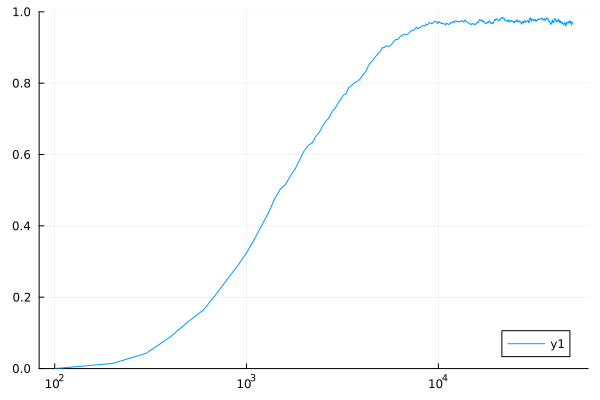

In [80]:
frs = [reshape(ff, (21,76)) for ff in f_sil]
plot([i*100 for i in 1:length(frs)], [ff[4,19] for ff in frs], xaxis=:log)
ylims!(0,1)

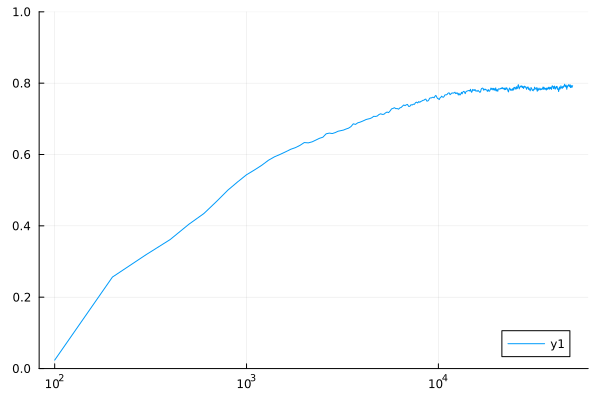

In [81]:
plot([i*100 for i in 1:length(f_sil)], [corspearman(f, ff) for ff in f_sil], xaxis=:log)
ylims!(0,1)

In [82]:
function filter_msa(nat_MSA, pinned_sites, pinned_aminos)
    nat_red = nat_MSA
    nat_red = nat_red[nat_red[:, pinned_sites[1]] .== pinned_aminos[1],:]
    for i in 2:length(pinned_sites)
        nat_red = nat_red[nat_red[:, pinned_sites[i]] .== pinned_aminos[i],:]
    end
    return nat_red
end


filter_msa (generic function with 1 method)

In [85]:
f_red = reshape(DCAUtils.compute_weighted_frequencies(Int8.(filter_msa(nat_MSA, 
                pinned_sites, pinned_aminos)'), 22, 0.2)[1], (21, 76));

θ = 0.2 threshold = 15.0
M = 1173 N = 76 Meff = 14.739486045889715


In [98]:
W = compute_weights(Int8.(nat_MSA'), 22, 0.2)

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705


([0.1111111111111111, 0.1111111111111111, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03225806451612903, 0.0625, 0.3333333333333333, 0.25, 0.003067484662576687  …  0.005405405405405406, 0.002531645569620253, 0.02040816326530612, 0.0017667844522968198, 0.0011261261261261261, 0.0011235955056179776, 0.0022624434389140274, 0.0014204545454545455, 0.3333333333333333, 0.0012836970474967907], 3129.1468140631705)

θ = 0.2 threshold = 15.0
M = 24944 N = 76 Meff = 3129.1468140631705
Computing statistics...
Performing eig factorization...
Largest eigenvalues: [1.8230030050439252, 1.984460140850855]
Done


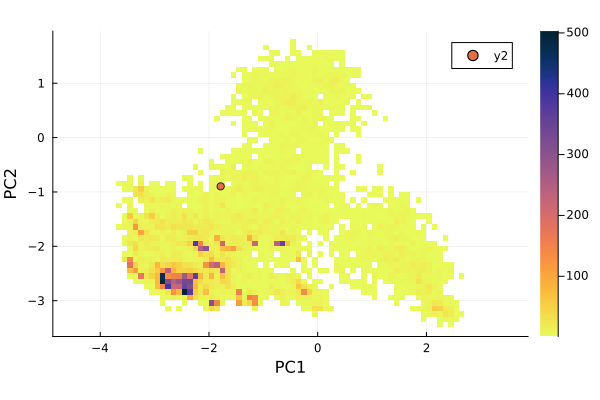

In [115]:
proj, (PC1, PC2) = perform_pca(nat_MSA)

plot_in_pc_space(proj[1],proj[2], nbins=60) #plotta tutte le sequenze su cui hai fatto PCA

wt_proj = get_projection((PC1,PC2), Int.(nat_MSA[1,:]))
s_proj_x = [wt_proj[1][1]] #coordinate della sequenza wt nello spazio PC
s_proj_y = [wt_proj[2][1]]

scatter!(s_proj_x, s_proj_y)

In [121]:
wt_proj = [get_projection((PC1,PC2), Int.(nat_red[i,:])) for i in 1:size(nat_red,1)];
wt_proj_nat = [get_projection((PC1,PC2), Int.(step_matrices[end][i,:])) 
    for i in 1:size(step_matrices[end], 1)];

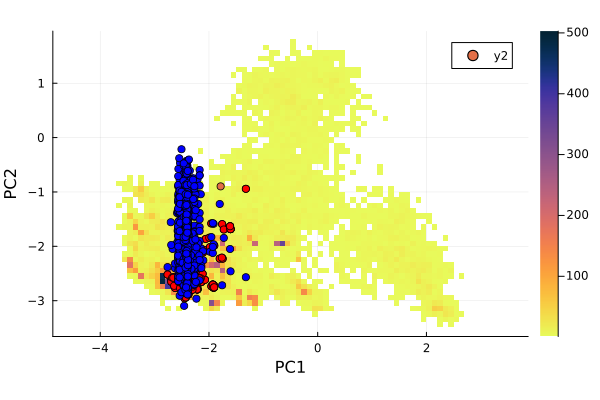

In [123]:
scatter!([wt_proj[i][1] for i in 1:length(wt_proj)], [wt_proj[i][2] for i in 1:length(wt_proj)], 
    color = "red", label = "")
scatter!([wt_proj[i][1] for i in 1:length(wt_proj_nat)], [wt_proj_nat[i][2] for i in 1:length(wt_proj_nat)], 
    color = "blue", label = "")

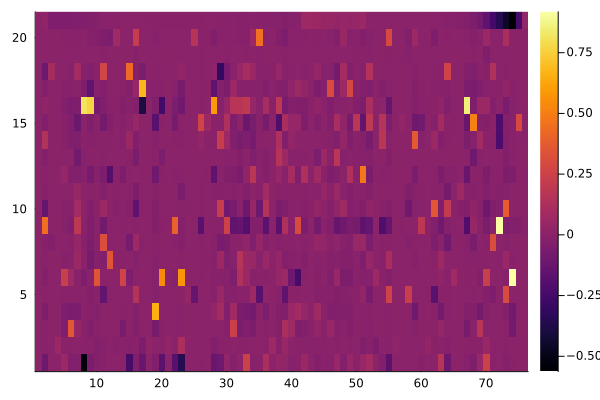

In [89]:
heatmap(f_red .-  frs_nat)

In [51]:
extrema(f_red .- frs_nat)

(-0.5630660070702254, 0.9182856590566939)